In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize']=10,6
import matplotlib.pyplot as plt

In [2]:
columns=[
'vendor name',
'Model Name',
'MYCT', 
'MMIN', 
'MMAX',
'CACH',
'CHMIN', 
'CHMAX', 
'PRP', 
'ERP', 
]

Attribute Information:
1. vendor name: 30 (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, sratus, wang)
2. Model Name: many unique symbols
3. MYCT: machine cycle time in nanoseconds (integer)
4. MMIN: minimum main memory in kilobytes (integer)
5. MMAX: maximum main memory in kilobytes (integer)
6. CACH: cache memory in kilobytes (integer)
7. CHMIN: minimum channels in units (integer)
8. CHMAX: maximum channels in units (integer)
9. PRP: published relative performance (integer)
10. ERP: estimated relative performance from the original article (integer)

In [3]:
df=pd.read_csv('./hardware.csv', names=columns)

In [52]:
df.head()

,vendor name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [53]:
df.columns

Index(['vendor name', 'Model Name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN',
       'CHMAX', 'PRP', 'ERP'],
      dtype='object')

In [4]:
df=df.rename(columns={'PRP' : 'Target'}).drop(['vendor name', 'Model Name', 'ERP'], axis=1)

In [5]:
df.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,Target
0,125,256,6000,256,16,128,198
1,29,8000,32000,32,8,32,269
2,29,8000,32000,32,8,32,220
3,29,8000,32000,32,8,32,172
4,29,8000,16000,32,8,16,132


In [6]:
import seaborn as sns

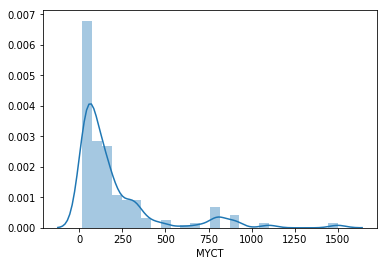

In [7]:
sns.distplot(df.MYCT)

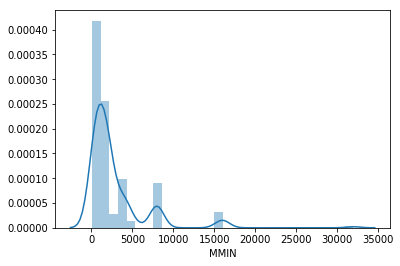

In [8]:
sns.distplot(df.MMIN)

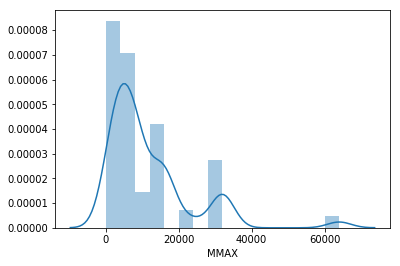

In [9]:
sns.distplot(df.MMAX)

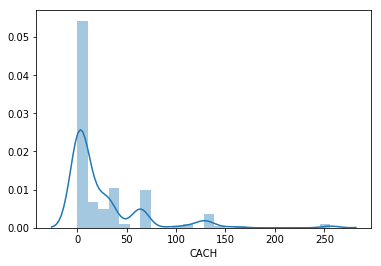

In [27]:
sns.distplot(df.CACH)

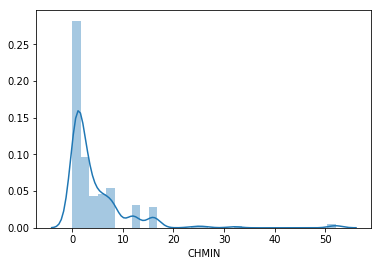

In [28]:
sns.distplot(df.CHMIN)

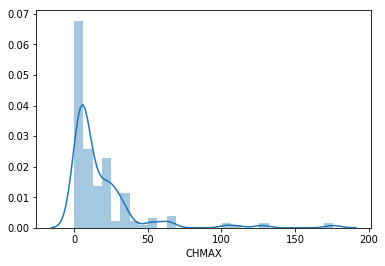

In [29]:
sns.distplot(df.CHMAX)

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
data_train, data_test, _, _ = train_test_split(df, df.Target, test_size=0.2)

In [13]:
data_train.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,Target
167,38,8000,16000,64,4,8,100
168,38,8000,24000,160,4,8,140
175,250,1000,16000,1,1,8,50
98,26,8000,16000,0,8,16,185
71,75,3000,8000,8,3,48,64


In [14]:
scaler=StandardScaler()
data_train_=np.hstack((scaler.fit_transform(data_train.drop('Target', axis=1)), np.array([data_train.Target.values]).T))
data_test_=np.hstack((scaler.transform(data_test.drop('Target', axis=1)), np.array([data_test.Target.values]).T))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
data_train_=pd.DataFrame(data_train_, columns=columns[2:8]+['Target'])
data_test_=pd.DataFrame(data_test_, columns=columns[2:8]+['Target'])

In [17]:
# Formula for Bayesian Linear Regression (follows R formula syntax)
formula = 'Target ~ ' + ' + '.join(['%s' % variable for variable in data_train.columns[:-1]])
formula

'Target ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX'

In [18]:
import pymc3 as pm

In [102]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = data_train_, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 100, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, CHMAX, CHMIN, CACH, MMAX, MMIN, MYCT, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:41<00:00, 26.38it/s]
The acceptance probability does not match the target. It is 0.957531170552674, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9736705095271222, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


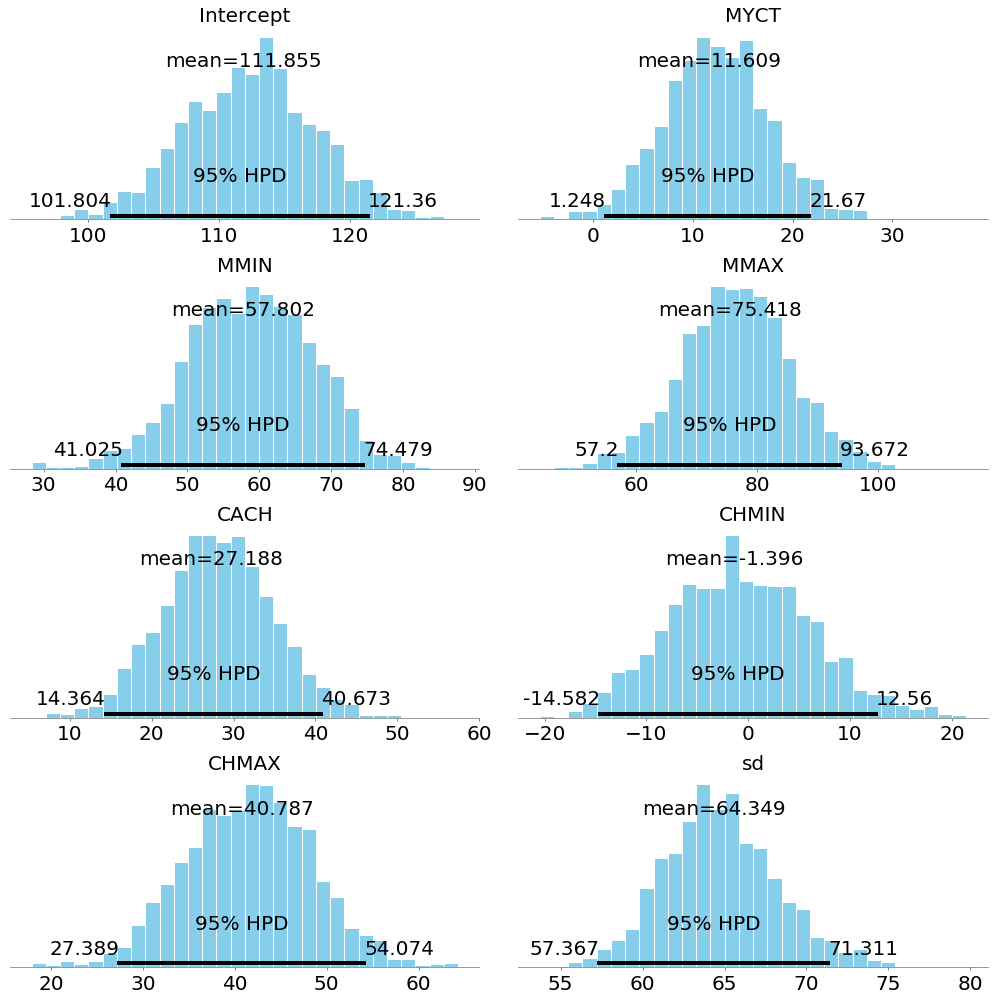

In [103]:
pm.plot_posterior(normal_trace, figsize = (14, 14), text_size=20);

In [112]:
# Print out the mean variable weight from the trace
weights=[]
for variable in normal_trace.varnames:
    w=np.mean(normal_trace[variable])
    weights.append((variable, w))
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, w))

Variable: Intercept       Mean weight in model: 111.8551
Variable: MYCT            Mean weight in model: 11.6091
Variable: MMIN            Mean weight in model: 57.8018
Variable: MMAX            Mean weight in model: 75.4182
Variable: CACH            Mean weight in model: 27.1880
Variable: CHMIN           Mean weight in model: -1.3965
Variable: CHMAX           Mean weight in model: 40.7868
Variable: sd_log__        Mean weight in model: 4.1628
Variable: sd              Mean weight in model: 64.3491


In [115]:
pd.DataFrame(sorted(weights, key=lambda x:x[1], reverse=True), columns=['feature', 'weight'])

,feature,weight
0,Intercept,111.855120
1,MMAX,75.418187
2,sd,64.349120
3,MMIN,57.801772
4,CHMAX,40.786767
5,CACH,27.188015
6,MYCT,11.609135
7,sd_log__,4.162834
8,CHMIN,-1.396475


# Linear model using mean values of parameters

In [27]:
model_formula = 'Target = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Target =  111.82 * Intercept + 11.46 * MYCT + 57.76 * MMIN + 75.21 * MMAX + 27.18 * CACH + -1.37 * CHMIN + 40.78 * CHMAX + 4.17 * sd_log__ + 64.51 * sd'

In [28]:
normal_trace.varnames

['Intercept',
 'MYCT',
 'MMIN',
 'MMAX',
 'CACH',
 'CHMIN',
 'CHMAX',
 'sd_log__',
 'sd']

In [108]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_test, y_test):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
#     print(var_means)
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns.drop('Target')
    X_test = X_test.ix[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.ix[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
#         print(np.dot(np.array(var_means), np.array(row[1])))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
#     return results

In [109]:
evaluate_trace(normal_trace, data_test_, data_test_.Target)

Model  MAE: 34.6845
Model RMSE: 40.7620


In [92]:
# Make a new prediction from the test set and compare to actual value
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['Target']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('Target')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    print(str(mean_loc)+" "+str(sd_value))
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    rcParams['figure.figsize']=8,8
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 5, 
               linestyles = '--', colors = 'red',
               label = 'True Target',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Target'); plt.ylabel('Density');
    
    # Prediction information
    print('True Target = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
MYCT          0.432848
MMIN         -0.655622
MMAX         -0.001046
CACH         -0.495840
CHMIN        -0.547135
CHMAX         0.164197
Target       53.000000
Intercept     1.000000
Name: 30, dtype: float64
72.88536046118645 64.34911982093293
True Target = 53
Average Estimate = 72.8854
5% Estimate = -37.7479    95% Estimate = 167.6260


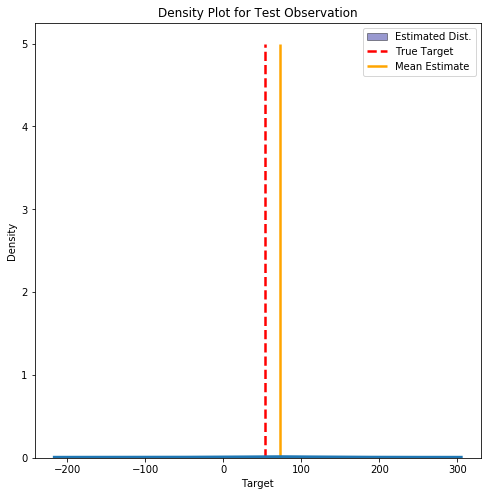

In [105]:
test_model(normal_trace, data_test_.iloc[30])